In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler

In [140]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
OUTLIERS_LABELLED = os.path.join(DATA_FOLDER, 'outliers_labelled.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [141]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

## Preliminary
Check the behaviour of each OD method on the dataset

In [145]:
# Redefine some stuff of used OD classes
# to obtain code continuity
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

class MyLOF(LocalOutlierFactor):
    name = "LOF"

    @property
    def scores(self): return self.negative_outlier_factor_

class MyABOD(ABOD):
    name = "ABOD"

    @property
    def scores(self): return self.decision_scores_

class MyISFO(IsolationForest):
    name = "ISFO"

    def fit(self, X):
        self._train_samp = X
        return super().fit(X)
    
    @property
    def scores(self): return self.score_samples(self._train_samp)

For each method finds the top `p%` outliers

In [330]:
p = 0.02

methods = [MyLOF, MyABOD, MyISFO]
params = [dict(n_jobs=-1), dict(), dict(n_jobs=-1)] # Parameters of the estimators

# The sub-samples in which the dataset is divided
# Currently the OD is performed on each element of (vocal_channel, sex) product category
locality_areas = []
for vc in ["song", "speech"]:
    for s in ["M","F"]:
        locality_areas.append(dict(vocal_channel=vc, sex=s))

for meth, pars in zip(methods, params):
    # Initiaizes each record not to be an outlier
    df[f"is_{meth.name}_outlier"] = False 
    for locality in locality_areas:
        locality_mask = np.array([(df[key] == val).values for key, val in locality.items()]).all(axis=0)
        N_p = int(p*np.sum(locality_mask))
        print(f"Taking {N_p} outliers for locality {list(locality.keys())}", end="")

        subsamp = MinMaxScaler().fit_transform( df.loc[locality_mask][numerical_attr_list].values )
        outlier_detector = meth(**pars)
        outlier_detector.fit(subsamp)
        df.loc[locality_mask, f"{meth.name}_score"] = outlier_detector.scores

        # Takes the worsts
        bad_kids = df.loc[locality_mask, f"{meth.name}_score"].nsmallest(N_p).index
        print(f" --> {bad_kids.values}")
        # Set them to be outliers
        df.loc[bad_kids,f"is_{meth.name}_outlier"] = True
        

Taking 10 outliers for locality ['vocal_channel', 'sex'] --> [ 698  927 1738 1757 1765 2304 1759  484 1756 1758]
Taking 9 outliers for locality ['vocal_channel', 'sex'] --> [ 382  589 2210 1206 1421 1241 1204 1240 1239]
Taking 14 outliers for locality ['vocal_channel', 'sex'] --> [ 832  841 1296  878    0 1481 1877 2248  425 1704  633 2282  223 2291]
Taking 14 outliers for locality ['vocal_channel', 'sex'] --> [1969 2392 1968 2375 1160 1982 2383 1177  544 1818  352  546  755  987]
Taking 10 outliers for locality ['vocal_channel', 'sex'] --> [2101 1319 1110 2105 2109 2100 2111 1335 2099 2097]
Taking 9 outliers for locality ['vocal_channel', 'sex'] --> [1634 1635  788 1994 2238 1995 2015 1639 1640]
Taking 14 outliers for locality ['vocal_channel', 'sex'] --> [1251 1249 1248 1302 1250 1258 1478 1666 1068 1279 1262 1078 1094 1267]
Taking 14 outliers for locality ['vocal_channel', 'sex'] --> [2170 1774  333 1779 2161  342  334 2144 1373 2165 1562 1354 2160 1987]
Taking 10 outliers for local

Now check whether the outliers have a predominant category

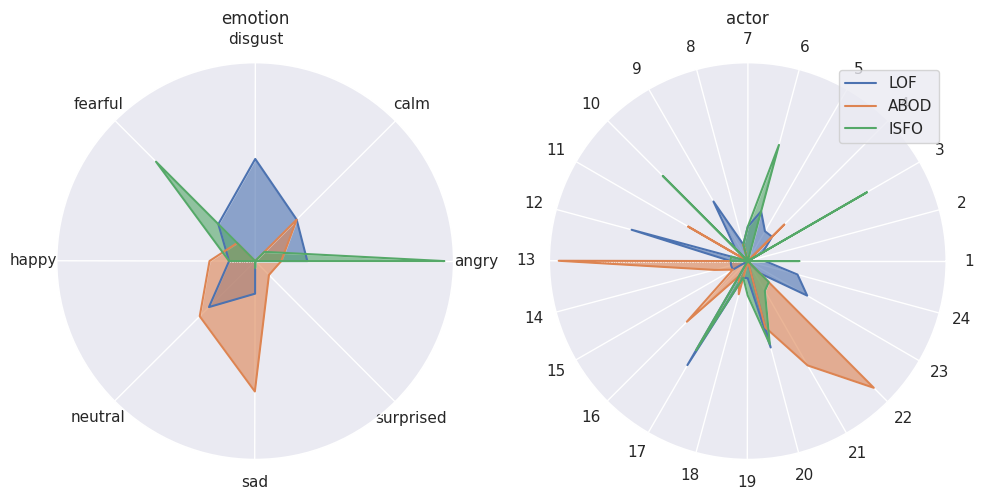

In [331]:
def plot_polar_closed(items, r, ax, **kwargs):
    items = list(items)
    asort = np.argsort(items)

    items = np.array(items)[asort]
    r = np.array(list(r))[asort]

    theta = np.linspace(0, 6.28, len(items), endpoint=False)

    theta = np.append(theta, theta[0])
    r = np.append(r, r[0])
    fill_kwargs = kwargs.copy()
    fill_kwargs["alpha"] = 0.6,
    fill_kwargs["label"] = ""

    ax.fill_between(theta,0*r, r, **fill_kwargs)
    ax.plot(theta, r, **kwargs)

    ax.set_xticks(theta[:-1], items)
    ax.set_rticks([])

fig, axes = plt.subplots(1,2, figsize=(10,8), subplot_kw={'projection': 'polar'})
for i, cat in enumerate(["emotion", "actor"]):
    cat_vals, cat_counts = np.unique(df[cat], return_counts=True)
    if cat =="actor":
        cat_vals = [int(act_name.split("_")[1]) for act_name in cat_vals]
    cat_counts = cat_counts/np.sum(cat_counts)

    for meth in methods:
        outlying_items, counts_num = np.unique(df.loc[df[f"is_{ meth.name}_outlier"], cat], return_counts=True)
        counts_num = counts_num/np.sum(counts_num)
        if cat == "actor":
            outlying_items = [int(act_name.split("_")[1]) for act_name in outlying_items]

        counts = {c:0 for c in np.unique(cat_vals)}
        for outlying_item, out_count, cc in zip(outlying_items, counts_num, cat_counts):
            # Normalize on category count
            # e.g.: More values of fear --> more outliers of fear
            counts[outlying_item] = out_count/cc

        plot_polar_closed(counts.keys(), counts.values(), axes[i], label=meth.name)

axes[i].legend()
axes[0].set_title("emotion");
axes[1].set_title("actor");

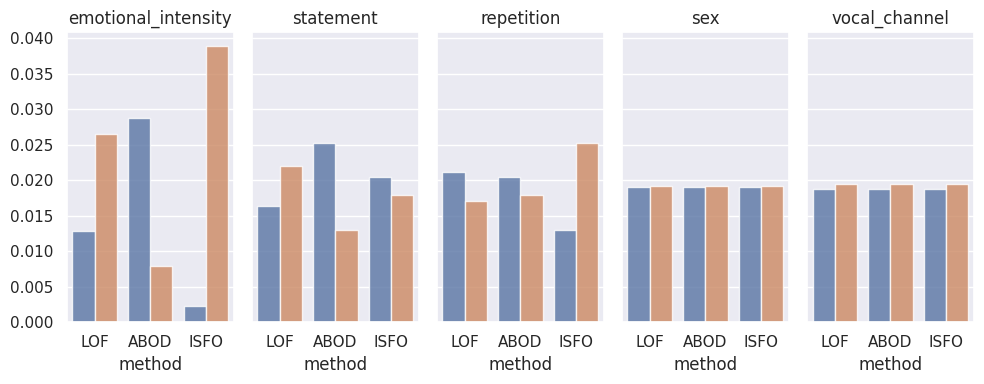

In [332]:
binary_categories = ["emotional_intensity",  "statement", "repetition", "sex", "vocal_channel",]
fig, axes = plt.subplots(1, len(binary_categories), figsize=(10, 4), sharey=True)
for cat, ax in zip(binary_categories, axes):
    small_df = pd.DataFrame()
    for meth in methods:
        o_values, o_counts = np.unique(df.loc[df[f"is_{meth.name}_outlier"], cat], return_counts = True)
        a_values, a_counts = np.unique(df[cat], return_counts = True)
        small_df = pd.concat([small_df, pd.DataFrame(dict(  method=[meth.name]*len(a_values), 
                                                            cat=cat,
                                                            rel_counts=o_counts/a_counts,
                                                            attr=a_values))])
        
    obj = sns.barplot(data=small_df,  x="method", y="rel_counts", ax=ax, hue="attr", alpha=0.8)
    ax.legend([], [], frameon=False)
    ax.set_title(cat)
    ax.set_ylabel("")
plt.tight_layout()

## Check into an embedding

In [338]:
from sklearn.manifold import Isomap
from umap import UMAP
reducer = UMAP(n_components=2, n_neighbors=100)
embedding = reducer.fit_transform(MinMaxScaler().fit_transform(df[numerical_attr_list]))

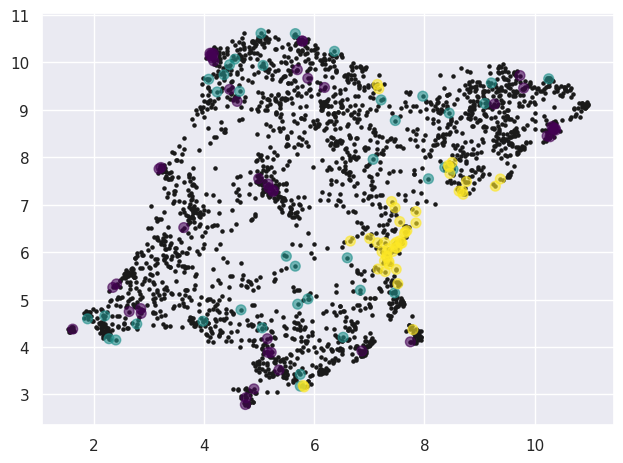

In [339]:
df["outlier_code"] = -1
code_map = dict(ABOD=1, LOF=2, ISFO=3)
for meth in methods:
    df.loc[df[f"is_{meth.name}_outlier"], "outlier_code"] = code_map[meth.name]

plt.scatter(*embedding.T, color="k", s=5)
plt.scatter(*(embedding[df.outlier_code != -1]).T, c=df.outlier_code[df.outlier_code != -1], alpha=0.6, s=50, cmap="viridis")


## Save results

In [335]:
df = df.reset_index(drop=True)
df.to_csv(NEW_DATASET, index=False)